In [1]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
from pykeops.torch import Genred

In [2]:
# ------------------------------------------------------------------
# 1) MHA implementations
# ------------------------------------------------------------------

class KeOpsMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        formula = '((Q|K)/D)'
        aliases = [
            f'Q = Vi({self.d_k})',
            f'K = Vj({self.d_k})',
            f'V = Vj({self.d_k})',
            'D = Pm(1)',
        ]
        formula2 = 'V'
        reduction_op = 'SumSoftMaxWeight'
        self.reduction = Genred(formula, aliases,
                                reduction_op=reduction_op,
                                formula2=formula2,
                                axis=1)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q_flat = Q.view(batch_size * self.num_heads, seq_len, self.d_k)
        K_flat = K.view(batch_size * self.num_heads, seq_len, self.d_k)
        V_flat = V.view(batch_size * self.num_heads, seq_len, self.d_k)

        D = torch.tensor([np.sqrt(self.d_k)], dtype=x.dtype, device=x.device)
        output_flat = self.reduction(Q_flat, K_flat, V_flat, D)

        output = output_flat.view(batch_size, self.num_heads, seq_len, self.d_k)
        output = output.reshape(batch_size, seq_len, d_model)
        return self.W_o(output)

In [3]:
class FlashMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # PyTorch's scaled_dot_product_attention can use fast kernels (Flash)
        attn_output = F.scaled_dot_product_attention(
            Q, K, V,
            attn_mask=None,
            dropout_p=0.0,
            is_causal=False
        )

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.W_o(attn_output)

In [4]:
# ------------------------------------------------------------------
# 2) Benchmark functions
# ------------------------------------------------------------------

def benchmark_time(module, input_generator, num_runs=10, backward=False):
    """
    Measures the average time (ms) for a forward (or forward+backward) pass.
    """
    # Warm-up
    for _ in range(5):
        x = input_generator()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()

    times = []
    for run in range(num_runs):
        x = input_generator()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.time()

        out = module(x)
        if backward:
            out.sum().backward()

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = (time.time() - start) * 1000.0  # ms
        times.append(elapsed)
    return np.mean(times), np.std(times)

def measure_memory_usage(module, input_generator, num_runs=5, backward=False):
    """
    Measures the peak GPU memory usage (in MB) for a forward (or forward+backward) pass.
    """
    usage = []
    for run in range(num_runs):
        torch.cuda.reset_peak_memory_stats(device=torch.cuda.current_device())
        x = input_generator()
        out = module(x)
        if backward:
            out.sum().backward()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        peak_bytes = torch.cuda.max_memory_allocated(device=torch.cuda.current_device())
        usage.append(peak_bytes)
    mean_usage = np.mean(usage) / (1024**2)  # Convert bytes -> MB
    std_usage = np.std(usage) / (1024**2)
    return mean_usage, std_usage

In [5]:
# ------------------------------------------------------------------
# 3) Main script to go over seq_len, d_model, num_heads, etc.
# ------------------------------------------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device:", device)

# Real-world Llama 2–style dimensions
model_configs = [
    ("Llama2-7B",   4096, 32),
    ("Llama2-13B",  5120, 40),
    ("Llama2-70B",  8192, 64),
]

# Sequence lengths to try
seq_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
batch_size = 4  

results = []

for model_name, d_model, num_heads in model_configs:
    print(f"\n--- Benchmarking {model_name} (d_model={d_model}, num_heads={num_heads}) ---")
    # Instantiate modules
    keops_attn  = KeOpsMultiHeadAttention(d_model, num_heads).to(device)
    flash_attn  = FlashMultiHeadAttention(d_model, num_heads).to(device)

    for seq_len in seq_lengths:
        print(f"\nSequence length = {seq_len}")

        # Define an input generator for this (seq_len, d_model)
        def input_gen():
            return torch.randn(batch_size, seq_len, d_model, device=device)

        t_k, t_k_std = benchmark_time(keops_attn, input_gen, num_runs=5, backward=False)
        m_k, m_k_std = measure_memory_usage(keops_attn, input_gen, num_runs=3, backward=False)

        t_f, t_f_std = benchmark_time(flash_attn, input_gen, num_runs=5, backward=False)
        m_f, m_f_std = measure_memory_usage(flash_attn, input_gen, num_runs=3, backward=False)

        # Store results
        results.append({
            "model": model_name,
            "d_model": d_model,
            "num_heads": num_heads,
            "seq_len": seq_len,
            "keops_time_ms": t_k,
            "keops_mem_MB": m_k,
            "flash_time_ms": t_f,
            "flash_mem_MB": m_f,
        })

        print(f"  [KeOps] time = {t_k:.2f} ms, mem = {m_k:.2f} MB")
        print(f"  [Flash] time = {t_f:.2f} ms, mem = {m_f:.2f} MB")

print("\nBenchmarking completed.")

Running on device: cuda

--- Benchmarking Llama2-7B (d_model=4096, num_heads=32) ---

Sequence length = 128
  [KeOps] time = 5.41 ms, mem = 614.79 MB
  [Flash] time = 3.88 ms, mem = 601.35 MB

Sequence length = 256
  [KeOps] time = 12.60 ms, mem = 708.33 MB
  [Flash] time = 8.03 ms, mem = 681.46 MB

Sequence length = 512
  [KeOps] time = 31.73 ms, mem = 895.42 MB
  [Flash] time = 16.87 ms, mem = 841.67 MB

Sequence length = 1024
  [KeOps] time = 91.43 ms, mem = 1271.25 MB
  [Flash] time = 33.27 ms, mem = 1162.08 MB

Sequence length = 2048
  [KeOps] time = 295.35 ms, mem = 2017.92 MB
  [Flash] time = 74.17 ms, mem = 1802.92 MB

Sequence length = 4096
  [KeOps] time = 1054.73 ms, mem = 3514.58 MB
  [Flash] time = 193.09 ms, mem = 3084.58 MB

Sequence length = 8192
  [KeOps] time = 3959.82 ms, mem = 6507.92 MB
  [Flash] time = 520.05 ms, mem = 5647.92 MB

Sequence length = 16384
  [KeOps] time = 15375.01 ms, mem = 12494.58 MB
  [Flash] time = 1551.83 ms, mem = 10774.58 MB

--- Benchmarkin

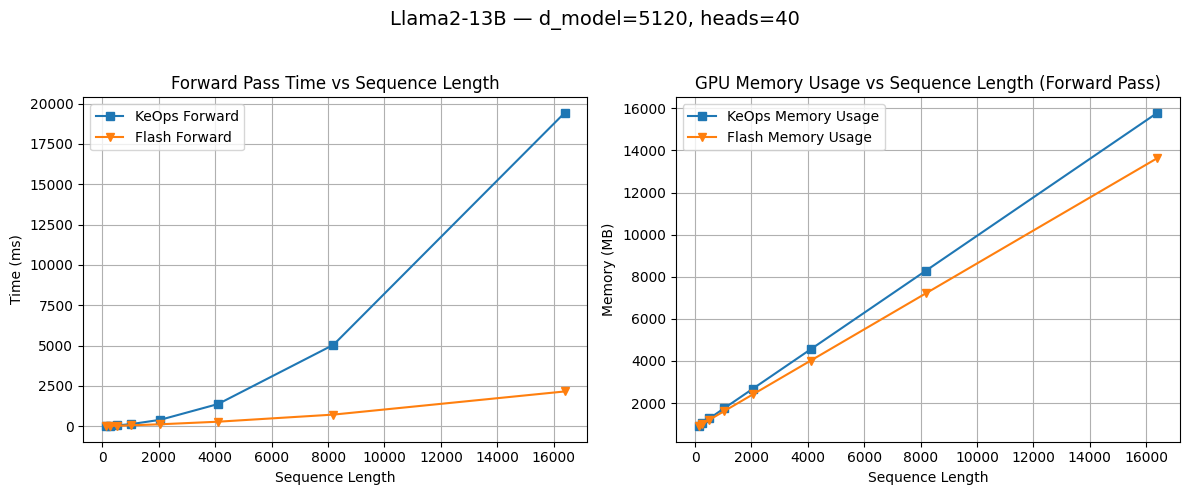

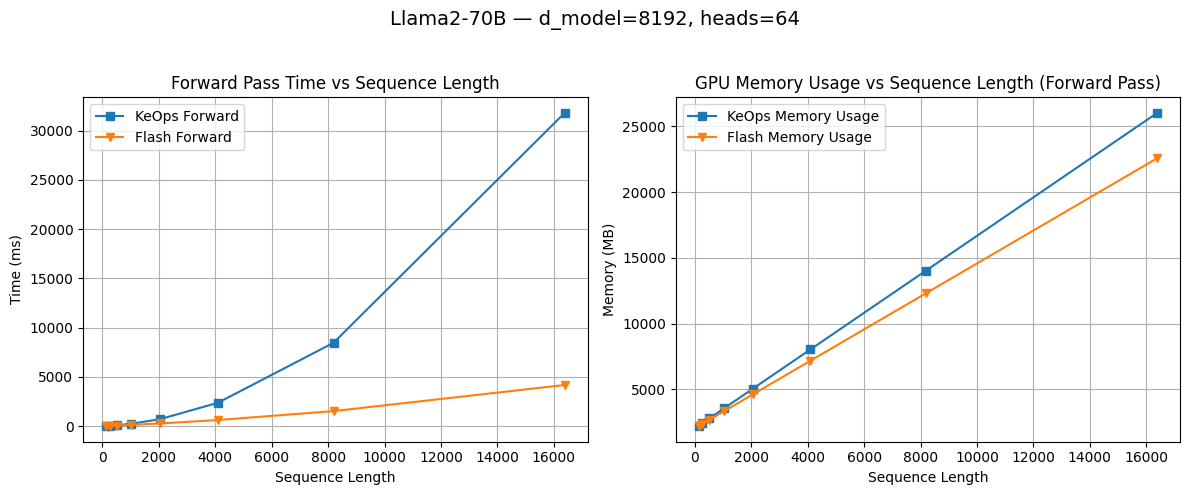

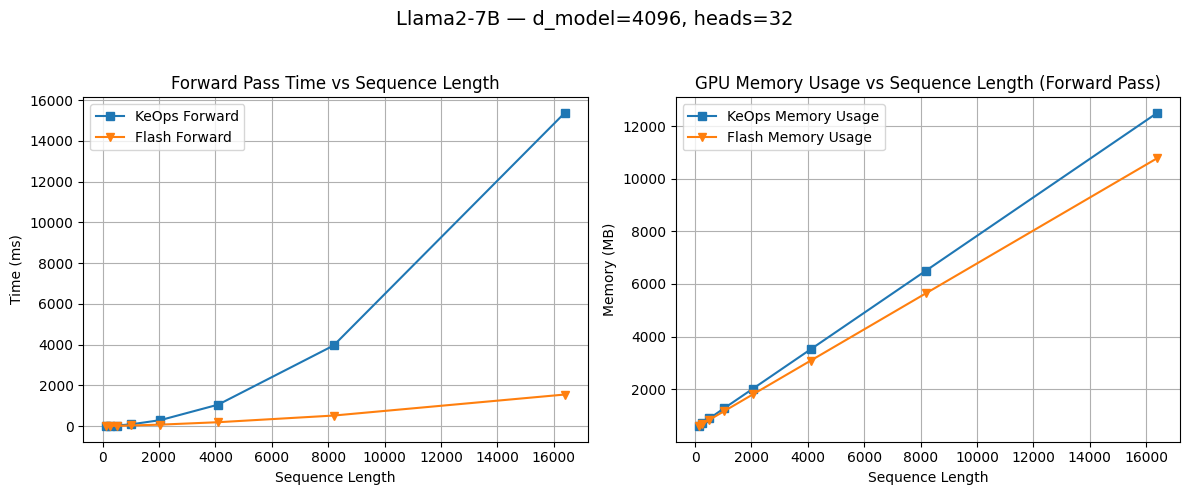

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# (Re‑use the DataFrame creation from earlier)
df = pd.DataFrame(results)

for (model, d_model, heads), grp in df.groupby(['model','d_model','num_heads']):
    grp = grp.sort_values('seq_len')
    seq = grp['seq_len']
    
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle(f"{model} — d_model={d_model}, heads={heads}", fontsize=14)

    # Time subplot
    plt.subplot(1, 2, 1)
    plt.plot(seq, grp['keops_time_ms'], marker='s', label="KeOps Forward")
    plt.plot(seq, grp['flash_time_ms'], marker='v', label="Flash Forward")
    plt.xlabel("Sequence Length")
    plt.ylabel("Time (ms)")
    plt.title("Forward Pass Time vs Sequence Length")
    plt.legend()
    plt.grid(True)

    # Memory subplot
    plt.subplot(1, 2, 2)
    plt.plot(seq, grp['keops_mem_MB'], marker='s', label="KeOps Memory Usage")
    plt.plot(seq, grp['flash_mem_MB'], marker='v', label="Flash Memory Usage")
    plt.xlabel("Sequence Length")
    plt.ylabel("Memory (MB)")
    plt.title("GPU Memory Usage vs Sequence Length (Forward Pass)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
